In [1]:
import re
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               FixedLocator)
from datetime import date, datetime, timedelta
import time
import glob
from joblib import Parallel, delayed
import xarray as xr
import sys
sys.path.insert(1, '/home/b/b382634/owl/owl')
from HW_detection_algorithm import *

In [2]:
### 1 SET-UP: Target temperature, HW definition and time period ###
var="tmax" #tmax,tmin

percent_thresh=90
duration_min=3

### TIME ###
clim_start=1981 #1981
clim_end=2010 #2010
period_start=1940
period_end=2022
if (period_end<clim_end) or (period_start>clim_start):
    raise Exception("Climatology period falls outside of target period")
years=[*range(period_start,period_end+1)]
climyears=[*range(clim_start,clim_end+1)]

nyear=len(years)
nclimyear=len(climyears)
nday=123 # days in period May to August
nrealisation=1 # ensemble members

In [3]:
# 2 LOCATION: Choose by longitude and latitude #
# Change from point to box #
#latN=
#latS=
...
name=""
# e.g.
# LAKE COMO  #
# region="LakeComo"
#lon = '''9°5'0"E'''
#lat = '''45°49'0"N'''

# Here are other examples - use wikipedia/google earth to search for your own! #
# STOCKHOLM #
region="Stockholm"
lon='''18°4'7"E'''
lat='''59°19'46"N'''
# MADRID #
#region="Madrid"
#lon='''3°42'12"E'''
#lat='''40°25'01"N'''

deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
latP= (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
deg, minutes, seconds, direction =  re.split('[°\'"]',lon)
lonP= (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

# Find nearest ERA5 cell #
def find_nearest(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [4]:
# 3 DATA: Open/extract ERA5 temperature data #

files=sorted(glob("/work/bk1318/b382634/ERA5/daily/*/{0}_*_EUR_MJJA.nc".format(var)))
ds=xr.open_mfdataset(files)

lons=ds.longitude.values
lats=ds.latitude.values
ind_lon=np.argwhere(lons==find_nearest(lons,lonP))[0]
ind_lat=np.argwhere(lats==find_nearest(lats,latP))[0]
t_data=ds[var].values[:,ind_lat,ind_lon].reshape(nyear,nday,1)

In [6]:
# 4 HW DETECTION: Run HW detection algorithm #
HW_output=calc_HWMIyear(t_data, climyears, years, cross_valid = False, percent_thresh = percent_thresh, duration_min = duration_min, opt="polyfit")

In [7]:
# 5 SAVE: HW occurrence used for Feature Selection (go to Notebook #2) #

dataset_out=xr.DataArray(HW_output['HW_occurrence'], dims=["year", "day"])
dataset_out.to_netcdf("HW_occurrence.nc")
#HW_occurrence

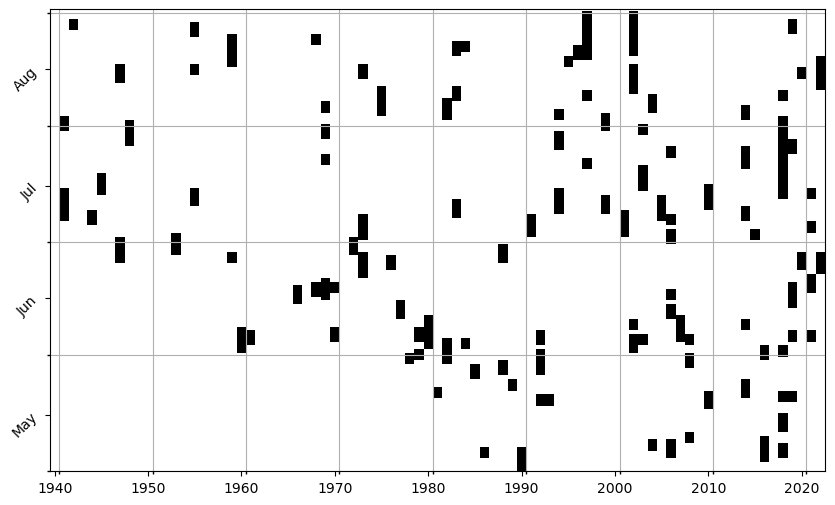

In [8]:
# 6 PLOTTING - optional #
# 6.1 2D TIME SERIES - HW OCCURRENCE #

fig,ax=plt.subplots(figsize=(10,6))

plt.pcolormesh(years,range(nday),HW_output['HW_occurrence'].T,cmap='binary')

plt.xticks(range(1940,2022,10))
plt.ylim([0,nday])
ticks=np.array([0,31,31+30,31+30+31])+15

plt.yticks(ticks,["May","Jun","Jul","Aug"],rotation=45)
ax.yaxis.set_minor_locator(FixedLocator(np.concatenate((ticks-15,np.array([31+30+31+30])))))
ax.xaxis.set_minor_locator(FixedLocator(np.arange(1940,2022,10)+0.5))
ax.tick_params(which='minor',width=1)

plt.plot([-1],[-1],'ks')

plt.xlim([1939.5,2022.5])
plt.grid(axis='y',which='minor')
plt.grid(axis='x',which='minor')
plt.show()

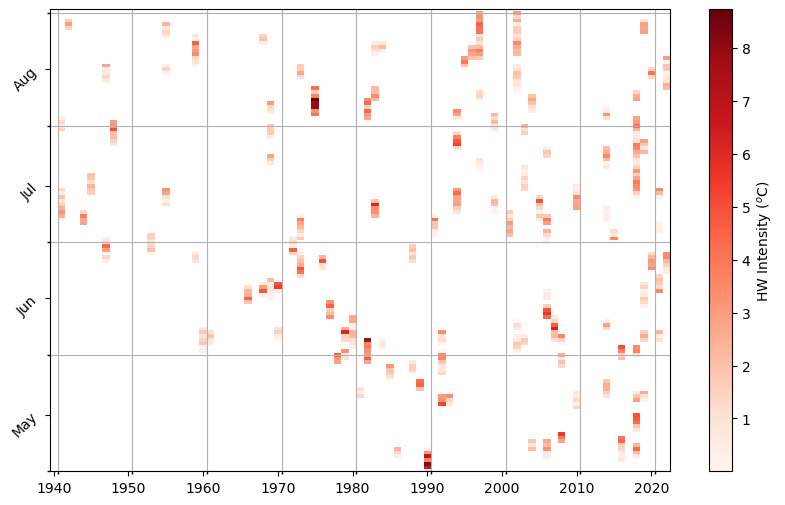

In [9]:
# 6.2 2D TIME SERIES - HW INTENSITY #

fig,ax=plt.subplots(figsize=(10,6))

plt.pcolormesh(years,range(nday),HW_output['HW_intensity_daily'].T,cmap='Reds')
plt.colorbar(label="HW Intensity ($^o$C)")
plt.xticks(range(1940,2022,10))
plt.ylim([0,nday])
ticks=np.array([0,31,31+30,31+30+31])+15

plt.yticks(ticks,["May","Jun","Jul","Aug"],rotation=45)
ax.yaxis.set_minor_locator(FixedLocator(np.concatenate((ticks-15,np.array([31+30+31+30])))))
ax.xaxis.set_minor_locator(FixedLocator(np.arange(1940,2022,10)+0.5))
ax.tick_params(which='minor',width=1)

plt.plot([-1],[-1],'ks')

plt.xlim([1939.5,2022.5])
plt.grid(axis='y',which='minor')
plt.grid(axis='x',which='minor')
plt.show()

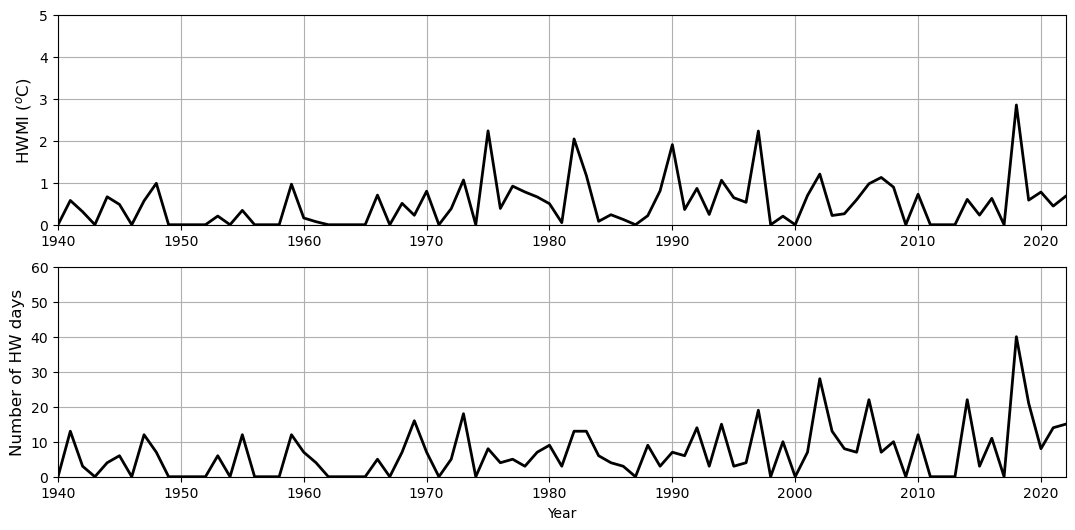

In [10]:
# 6.3 HWMI/Number of days (annual time series) #
fig, axs = plt.subplots(2, 1, figsize=(13, 6))

axs[0].plot(years, HW_output['HWMI_year'], '-', lw=2, c='black',zorder=5)
axs[0].set_ylabel("HWMI ($^o$C)",fontsize=12)
axs[0].set_ylim([0,5])

axs[1].plot(years, np.sum(HW_output['HW_occurrence'],axis=1), '-', lw=2, c='black',zorder=5)
axs[1].set_ylabel("Number of HW days",fontsize=12)
axs[1].set_ylim([0,60])

axs[1].set_xlabel("Year")

for i in range(2):
    axs[i].set_xlim([1940,2022])
    axs[i].grid(zorder=1)

# Display the subplots
plt.show()